In [ ]:
    import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [816]:
# Chargement des images
image_ref_name = "Reference.JPG"

#image_trait_name = "IMG_6560.JPG"
#image_folder = "Salon"

image_trait_name = "IMG_6573.JPG"
image_folder = "Chambre"


#image_trait_name = "IMG_6565.JPG"
#image_folder = "Cuisine"


image_ref_path = os.path.join('.', 'Colab', image_folder, image_ref_name)
image_trait_path = os.path.join('.', 'Colab', image_folder, image_trait_name)

image_ref = cv2.imread(image_ref_path)
image_trait = cv2.imread(image_trait_path)

In [817]:
# Vérification du chargement des images
if image_ref is None:
    raise FileNotFoundError(f"Image de référence non trouvée à {image_ref_path}")
if image_trait is None:
    raise FileNotFoundError(f"Image à traiter non trouvée à {image_trait_path}")

# Informations sur les photos
print("Image de référence détails :", image_ref.shape)
print("Image à traiter détails :", image_trait.shape)

# Conversion BGR en RGB
image_ref_rgb = cv2.cvtColor(image_ref, cv2.COLOR_BGR2RGB)
image_trait_rgb = cv2.cvtColor(image_trait, cv2.COLOR_BGR2RGB)

Image de référence détails : (4000, 6000, 3)
Image à traiter détails : (4000, 6000, 3)


In [818]:
# Fonction de redimensionnement
def resizer_image(image, scale_percent):
    if scale_percent <= 0:
        raise ValueError("scale_percent doit être supérieur à 0")
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

# Redimensionnement des images
image_ref_min = resizer_image(image_ref_rgb, 50)
image_trait_min = resizer_image(image_trait_rgb, 50)

In [819]:
def aligner_images(img_ref, img_act, max_features=500, good_match_percent=0.15):
    # Vérifier si les images sont en RGB et les convertir en niveaux de gris
    gris_ref = cv2.cvtColor(img_ref, cv2.COLOR_RGB2GRAY)
    gris_act = cv2.cvtColor(img_act, cv2.COLOR_RGB2GRAY)

    # Initialiser le détecteur ORB avec des paramètres ajustés
    orb = cv2.ORB_create(nfeatures=max_features)

    # Détecter les points clés et calculer les descripteurs
    kp1, des1 = orb.detectAndCompute(gris_ref, None)
    kp2, des2 = orb.detectAndCompute(gris_act, None)

    # Vérifier que des descripteurs ont été trouvés
    if des1 is None or des2 is None:
        raise ValueError("Pas assez de points clés détectés pour l'alignement.")

    # Initialiser le matcher BFMatcher avec KNN
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # Trouver les correspondances avec KNN
    matches = bf.knnMatch(des1, des2, k=2)

    # Appliquer le ratio test de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    print(f"Nombre de bonnes correspondances après le ratio test : {len(good_matches)}")

    # Vérifier qu'il y a suffisamment de bonnes correspondances
    if len(good_matches) < 4:
        raise ValueError("Pas assez de bonnes correspondances pour calculer l'homographie.")

    # Limiter le nombre de bonnes correspondances
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    good_matches = good_matches[:int(len(good_matches) * good_match_percent)]

    # Extraire les points de correspondance
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Calculer l'homographie
    homographie, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)

    if homographie is None:
        raise ValueError("Homographie non trouvée.")

    # Appliquer la transformation homographique à l'image actuelle
    img_act_alignee = cv2.warpPerspective(img_act, homographie, (img_ref.shape[1], img_ref.shape[0]))

    # Optionnel : Visualiser les correspondances avec Matplotlib
    img_matches = cv2.drawMatches(img_ref, kp1, img_act, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 7))
    plt.imshow(img_matches)
    plt.title('Correspondances')
    plt.axis('off')
    plt.show()

    return img_act_alignee

In [820]:
def appliquer_clahe_hsv(image, clip_limit=2.0, tile_grid_size=(8, 8)):

    # Convertir l'image de RGB à HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Séparer les canaux H, S, V
    h, s, v = cv2.split(hsv)
    
    # Initialiser CLAHE avec les paramètres spécifiés
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Appliquer CLAHE uniquement sur le canal V
    v_clahe = clahe.apply(v)
    
    # Recomposer l'image HSV avec le canal V amélioré
    hsv_clahe = cv2.merge((h, s, v_clahe))
    
    # Convertir l'image HSV de retour en BGR
    image_clahe = cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2RGB)
    
    return image_clahe

In [821]:
def appliquer_clahe_lab(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l)
    
    lab_clahe = cv2.merge((l_clahe, a, b))
    image_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    
    return image_clahe

In [822]:
def appliquer_clahe_rgb(image, clip_limit=2.0, tile_grid_size=(8, 8)):

    # Séparer les canaux R,G,B
    r, g, b = cv2.split(image)
    
    # Appliquer CLAHE sur chaque canal
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
 
    r_clahe = clahe.apply(r)
    g_clahe = clahe.apply(g)
    b_clahe = clahe.apply(b)

    
    # Recomposer l'image
    image_clahe = cv2.merge((r_clahe, g_clahe,b_clahe ))

    
    return image_clahe

In [823]:
def appliquer_clahe_ycrcb(image, clip_limit=2.0, tile_grid_size=(8, 8)):
  

    # Convertir l'image en YCrCb
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    # Séparer les canaux
    y, cr, cb = cv2.split(ycrcb)
    
    # Appliquer CLAHE sur le canal Y
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    y_clahe = clahe.apply(y)
    
    # Recomposer l'image avec le canal Y amélioré
    ycrcb_clahe = cv2.merge((y_clahe, cr, cb))
    
    # Convertir de retour en BGR
    image_clahe = cv2.cvtColor(ycrcb_clahe, cv2.COLOR_YCrCb2RGB)
    
    return image_clahe

In [824]:
def soustraction_arriere_plan(img_ref_alignee, img_trait_alignee):
    # Convertir en niveaux de gris
    gray_ref = cv2.cvtColor(img_ref_alignee, cv2.COLOR_RGB2GRAY)
    gray_trait = cv2.cvtColor(img_trait_alignee, cv2.COLOR_RGB2GRAY)

    #image_gris_ref_equal = cv2.equalizeHist(gray_ref)
    #image_gris_act_equal = cv2.equalizeHist(gray_trait)
    
    # Calculer la différence absolue
    diff = cv2.absdiff(gray_ref, gray_trait)
    
    # Appliquer un seuillage pour obtenir une image binaire
    #_, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
        #_, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY_INV)
    #_, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #_, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_TRUNC)
    #_, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_TOZERO)
    #_, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_TOZERO_INV)
    _, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_TRIANGLE)

    #mask  = cv2.adaptiveThreshold(diff, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # Optionnel : Appliquer des opérations morphologiques pour éliminer le bruit
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask

In [825]:
# Fonction de détection de contours
def detecter_contours(mask):
    #contours = cv2.Canny(mask, 100, 200)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

In [826]:
#onction pour tracer les contours

def tracer_contour(image_originale, min_area, max_area, color=(0, 255, 0), thickness=2):
    # Copier l'image originale pour dessiner les rectangles
    image_contours = image_originale.copy()

    for cnt in contours:
        area = cv2.contourArea(cnt)

        # Filtrer les contours par aire
        if min_area < area < max_area:
            # Obtenir le rectangle englobant aligné aux axes
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(image_contours, (x, y), (x + w, y + h), color, thickness)

    return image_contours


Nombre de bonnes correspondances après le ratio test : 264


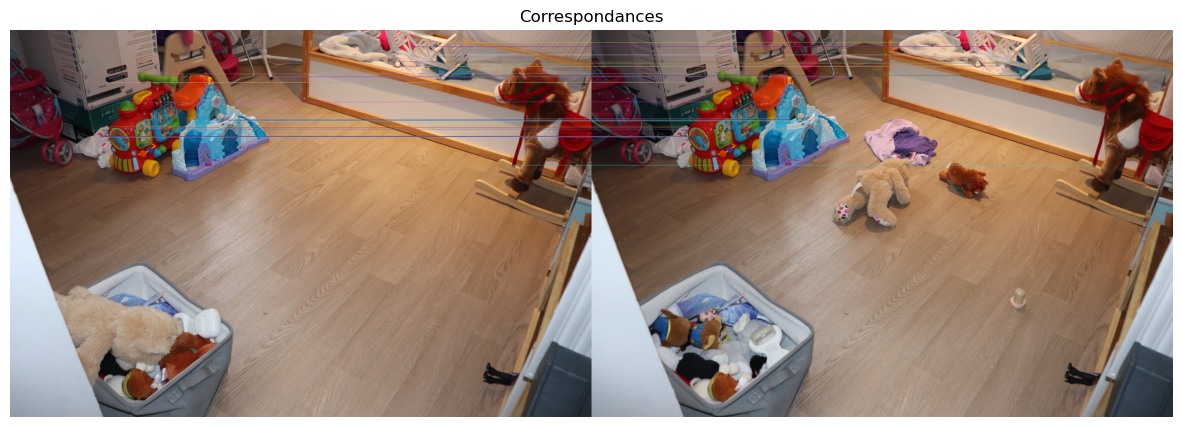

In [827]:
# Aligner les images
image_trait_alignee = aligner_images(image_ref_min, image_trait_min)

# Appliquer CLAHE
image_ref_clahe = appliquer_clahe_rgb(image_ref_min)
    image_trait_clahe = appliquer_clahe_rgb(image_trait_alignee)


(-0.5, 2999.5, 1999.5, -0.5)

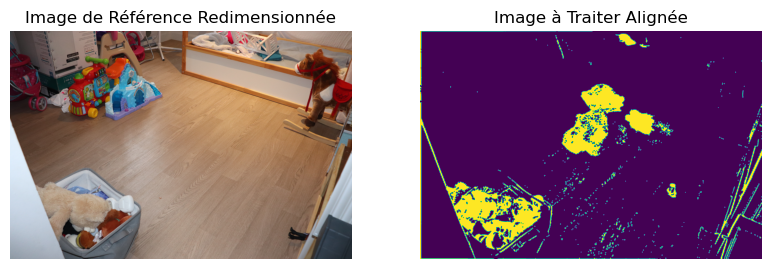

In [828]:
# Soustraction d'arrière-plan
mask = soustraction_arriere_plan(image_ref_clahe, image_trait_clahe)

# Détection de contours
contours = detecter_contours(mask)

# Afficher les résultats
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title("Image de Référence Redimensionnée")
plt.imshow(image_ref_min)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Image à Traiter Alignée")
plt.imshow(mask)
plt.axis('off')


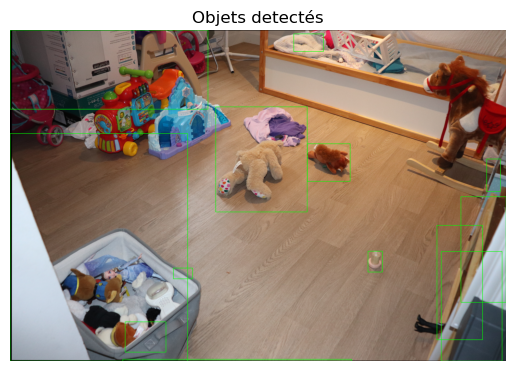

In [829]:
# Détection et tracé des contours
image_contours = tracer_contour(image_trait_alignee, min_area=3000, max_area=1000000)

# Exemple d'utilisation

plt.imshow(image_contours)
plt.title('Objets detectés')
plt.axis('off')
plt.show()
    